In [7]:
%run ../scripts/lab3_analysis_functions.py

In [8]:
filename = '../data/cs2.h5'
hf = tables.open_file(filename, "r")
raw_data_1 = import_data(filename)
event_data_cs1= hf.root.EventData.read()
hf.close()

In [9]:
# filename = '/Users/Asia/Desktop/204/lab3/lab3/data/am1.h5'
# hf = tables.open_file(filename, "r")
# raw_data_1 = import_data(filename)
# event_data_am1= hf.root.EventData.read()
# hf.close()

# filename = '/Users/Asia/Desktop/204/lab3/lab3/data/am2.h5'
# hf = tables.open_file(filename, "r")
# raw_data_2 = import_data(filename)
# event_data_am2= hf.root.EventData.read()
# hf.close()

# filename = '/Users/Asia/Desktop/204/lab3/lab3/data/cs1.h5'
# hf = tables.open_file(filename, "r")
# raw_data_1 = import_data(filename)
# event_data_cs1= hf.root.EventData.read()
# hf.close()

# filename = '/Users/Asia/Desktop/204/lab3/lab3/data/cs2.h5'
# hf = tables.open_file(filename, "r")
# raw_data_2 = import_data(filename)
# event_data_cs2= hf.root.EventData.read()
# hf.close()

In [10]:
# event_data_am = np.concatenate((event_data_am1, event_data_am2))
# event_data_cs = np.concatenate((event_data_cs1, event_data_cs2))

In [12]:
# sort events by timestamp
event_data_cs1 = event_data_cs1[np.argsort(event_data_cs1['timestamp'])]

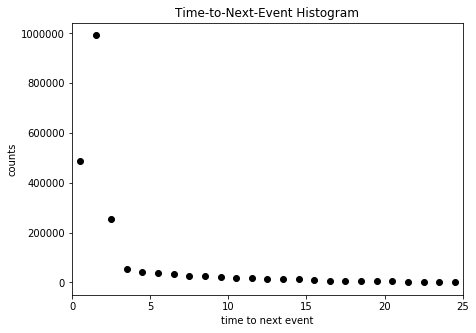

In [13]:
time_btwn_events = np.diff(event_data_cs1['timestamp'])
counts, bin_edges = np.histogram(time_btwn_events, bins=30, range = [0, 30])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.figure(4, figsize=(7, 5))
plt.cla()
plt.clf()
plt.plot(bins, counts, 'ko')
plt.xlabel('time to next event')
plt.ylabel('counts')
plt.title("Time-to-Next-Event Histogram")
plt.xlim([0, 25])
plt.savefig("../figures/time-to-next-event.pdf")
plt.show()

In [14]:
print('applying energy calibration to data files...')
print('(this part takes a bit of time)')

filename = '../data/calibration.txt'
calibration = np.genfromtxt(filename,delimiter=' ')
slopes = calibration[:,0]
intercepts = calibration[:,1]

for i in range(0, 152, 1):
    mask = (event_data_cs1['detector'] == i)
    event_data_cs1['ADC_value'][mask] = calculate_energies(event_data_cs1['ADC_value'][mask], slopes[i], intercepts[i])
    if i == 90:
        print('still going... almost done')
    if i == 152:
        print('phew! done with that part')
    

applying energy calibration to data files...
(this part takes a bit of time)
still going... almost done


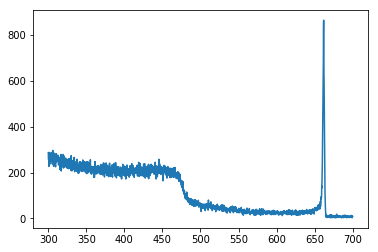

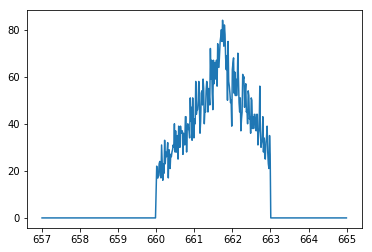

In [15]:
counts, bin_edges = np.histogram(event_data_cs1['ADC_value'], bins=2048, range = [300, 700])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(bins, counts)
plt.savefig('../figures/energy-spectrum.pdf')
plt.show()


mask_1 = ((660 < event_data_cs1['ADC_value']) & (event_data_cs1['ADC_value'] < 663))
counts, bin_edges = np.histogram(event_data_cs1['ADC_value'][mask_1], bins=500, range = [657, 665])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(bins, counts)
plt.savefig('../figures/energy-spectrum-cut.pdf')
plt.show()

In [19]:
import h5py

In [35]:
print(len(raw_data_1))
print(len(event_data_cs1))
print(len(event_data_cs1[mask_1]))

2559802
2559802
8317


In [45]:
# baseline correct raw pulses
raw_data_1 = fast_baseline_correction(raw_data_1)

In [48]:
def make_test_file(masked_data, rawdata):
    f = open('test.csv', 'w')
    for i in event_data_cs1[mask_1]:
        #print(i)
        f.write(str(i[0]) +','+ str(i[1]) + ','+str(i[2]) + ','+ str(i[3]) + ','+ str(i[4]) + ','+ str(i[5]) + ','+ str(i[6]) + '\n')
    f.close()

    f = open('test_trace.csv', 'w')
    for i in event_data_cs1['rid'][mask_1]:
        x = rawdata[i]
        for j in x:
            f.write(str(j) + ' ')
        f.write('\n')
    f.close()

#make_test_file(event_data_cs1[mask_1], raw_data_1)

In [49]:
# full energy only
mask_1 = ((640 < event_data_cs1['ADC_value']) & (event_data_cs1['ADC_value'] < 680))
print(event_data_cs1['ADC_value'][mask_1][0:10])

[ 677.69152832  658.96270752  660.75109863  662.43505859  661.61340332
  658.53735352  662.78399658  648.70495605  663.44604492  676.03094482]


In [38]:
#dc1, dc2, ac1, ac2
face1 = np.arange(0, 38) # dc1 
face2 = np.arange(38, 76) # dc2
face3 = np.arange(76, 114) # ac1
face4 = np.arange(114, 152) # ac2

In [79]:
def calculate_t50(signal, plot=False):
    signal = signal[:-100]
    x = np.linspace(0, len(signal) -100, len(signal) -99)
   # print(x)
    sig = savgol_filter(signal, 15, 3) # window size 51, polynomial order 3

    if sig.all() == 0:
        return -1000
    elif np.argmax(sig) == len(sig):
        return -1000
    else:
        grad = np.amax(np.gradient(sig)) / 10
      
        maxval = np.amax(sig)
        fiftyval = maxval* 0.5

        for i in range(0, np.argmax(sig) +1, 1):
            if sig[i] <= fiftyval:
                fiftyindex = i

        if (fiftyindex + 3) == len(sig):
            x_fit_low = x[int(fiftyindex - 2): len(sig)]
            sig_fit_low = sig[int(fiftyindex - 2): len(sig)]          
        else:
            x_fit_low = x[int(fiftyindex - 2): int(fiftyindex + 3)]
            sig_fit_low = sig[int(fiftyindex - 2): int(fiftyindex + 3)]
        if len(x_fit_low) != len(sig_fit_low):
            print(fiftyindex)
            print(len(x_fit_low))
            print(len(sig_fit_low))
            print(x_fit_low)
            print(sig_fit_low)
            plt.plot(signal)
            plt.plot(sig)
            plt.show()
            plt.plot(signal[int(fiftyindex - 4):int(fiftyindex + 5)], 'o')
            plt.plot(sig[int(fiftyindex -4): int(fiftyindex + 5)], 'o')
            plt.show()
            x_fit_low = x[int(fiftyindex -2): int(fiftyindex +2)]
            sig_fit_low = sig[int(fiftyindex -2): int(fiftyindex +2)]
            print(len(x_fit_low))
            print(len(sig_fit_low))
        x_fit_low = np.array(x_fit_low)
        sig_fit_low = np.array(sig_fit_low)
        if len(x_fit_low) < 1:
            print('x empty')
            plt.plot(signal)
            plt.plot(sig)
            plt.show()
            return -1
        else:
            m, b = np.polyfit(x_fit_low, sig_fit_low, deg=1)
            fit_low = b + m * x_fit_low
            rise_low = ((fiftyval - b )/ m)

        t50 = (rise_low) * 10# ns

        if plot==True:
            plt.figure(figsize=(10,5))
            plt.plot(signal, '-', label = 'raw signal')
            plt.plot(sig, label = 'smoothed signal')
            plt.plot(x_fit_low, fit_low,'-', linewidth = 5.0,alpha=0.7, label = 'fit')
            plt.plot(t50/10, fiftyval, 'ro', label='t50')
            plt.title('T50 Fitting')
            plt.ylabel('ADC value')
            plt.xlabel('ADC sample (10 ns sampling time)')
            plt.legend()
            #plt.savefig('t50_fitting.pdf')
            plt.show()
        return t50

In [78]:
#x = 7000
diff1vals = []
flag = 0 # 1 = detector1, 2= detector2, 3=detector1 neighbors, 4=detector2 neigbors, 5=other
delta_t50_values_1 = []
delta_t50_values_2 = []
for t in range(0, len(event_data_cs1['timestamp'][mask_1]), 1):
#for t in range(0, x, 1):
    diff0 = np.abs(event_data_cs1['timestamp'][mask_1][t] - event_data_cs1['timestamp'][mask_1][t-1])
    # diff1 = np.abs(event_data_cs1['timestamp'][mask_1][t] - event_data_cs1['timestamp'][mask_1][t-2])
    # diff2 = np.abs(event_data_cs1['timestamp'][mask_1][t+1] - event_data_cs1['timestamp'][mask_1][t])
    # diff3 = np.abs(event_data_cs1['timestamp'][mask_1][t+2] - event_data_cs1['timestamp'][mask_1][t])
    if diff0 < 50:
        # print('0', diff0)
        # print('1', diff1)
        # print('2', diff2)
        # print('3', diff3)
        detector1 = (event_data_cs1['detector'][mask_1][t-1])
        detector2 = (event_data_cs1['detector'][mask_1][t])
        #print('-------------')
        
        if detector1 in face1 and detector2 in face1:
            # print('face1 neighbors')
            flag = 3
        elif detector1 in face2 and detector2 in face2:
            # print('face2 neighbors')
            flag = 3
        elif detector1 in face3 and detector2 in face3:
            # print('face3 neighbors')
            flag = 4
        elif detector1 in face4 and detector2 in face4:
            # print('face4 neighbors')
            flag = 4
            
        elif detector1 in face1 and detector2 in face3:
            # print('detector1')
            flag  = 1
        elif detector1 in face3 and detector2 in face1:
            # print('detector1')
            flag  = 1
        elif detector1 in face2 and detector2 in face4:
            # print('detector2')
            flag  = 2
        elif detector1 in face4 and detector2 in face2:
            # print('detector2')
            flag  = 2
        else:
            flag= 5
            # print('other')
            
        if flag == 1:
            rid1 = (event_data_cs1['rid'][mask_1][t-1])
            rid2 = (event_data_cs1['rid'][mask_1][t])
            adc1 = (event_data_cs1['ADC_value'][mask_1][t-1])
            adc2 = (event_data_cs1['ADC_value'][mask_1][t])

            t501 = calculate_t50(raw_data_1[rid1], plot=False)
            t502 = calculate_t50(raw_data_1[rid2], plot=False)
            if rid1 > rid2: # electrons - holes = ac - dc
                #deltat50 = -(diff0 * 10) - t502 + t501 #- diff0 * 10
                deltat50 = (diff0 * 10) + t502 - t501
            else:  # rid1 < rid2
                #deltat50 = (diff0 * 10) + t502 - t501 #- diff0 * 10 
                deltat50 = -(diff0 * 10) - t502 + t501
            deltat50 = round(float(deltat50),4)
            delta_t50_values_1.append(deltat50)
            diff1vals.append(diff0) 
                    
        elif flag == 2:
            rid1 = (event_data_cs1['rid'][mask_1][t-1])
            rid2 = (event_data_cs1['rid'][mask_1][t])
            adc1 = (event_data_cs1['ADC_value'][mask_1][t-1])
            adc2 = (event_data_cs1['ADC_value'][mask_1][t])
            t501 = calculate_t50(raw_data_1[rid1], plot=False)
            t502 = calculate_t50(raw_data_1[rid2], plot=False)
            
            if rid1 > rid2: # electrons - holes = ac - dc
                #deltat50 = -(diff0 * 10) - t502 + t501 #- diff0 * 10
                deltat50 = (diff0 * 10) + t502 - t501
            else:  # rid1 < rid2
                #deltat50 = (diff0 * 10) + t502 - t501 #- diff0 * 10 
                deltat50 = -(diff0 * 10) - t502 + t501

            deltat50 = round(float(deltat50),4)
            delta_t50_values_2.append(deltat50)
            diff1vals.append(diff0) 
        else:
            continue

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ulong_scalars
  


IndexError: index 156 is out of bounds for axis 0 with size 156

In [ ]:
print(len(delta_t50_values_1))
print(len(delta_t50_values_2))
delta_t50_1 = np.asarray(delta_t50_values_1)#, dtype=float)
#print(type(delta_t50_1))
counts_det1, bin_edges = np.histogram(delta_t50_1, bins=400, range = [-250, 250])
bins_det1 = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(bins_det1, counts_det1)
#plt.xlim([-10,222])
plt.savefig('../figures/t50s_det1.pdf')
plt.show()

delta_t50_2 = np.asarray(delta_t50_values_2)#, dtype=float)
#print(type(delta_t50_1))
counts_det2, bin_edges = np.histogram(delta_t50_2, bins=400, range = [-250, 250])
bins_det2 = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(bins_det2, counts_det2)
#plt.xlim([-10,222])
plt.savefig('../figures/t50s_det2.pdf')
plt.show()

[[Model]]
    Model(exponential, prefix='exp_')
[[Fit Statistics]]
    # function evals   = 64
    # data points      = 400
    # variables        = 2
    chi-square         = 1162.739
    reduced chi-square = 2.921
    Akaike info crit   = 430.828
    Bayesian info crit = 438.811
[[Variables]]
    exp_amplitude:   1.89495692 +/- 0.091121 (4.81%) (init= 0.0001145113)
    exp_decay:      -530.940370 +/- 89.34704 (16.83%) (init=-24.84579)
[[Correlations]] (unreported correlations are <  0.100)
    C(exp_amplitude, exp_decay)  = -0.488 



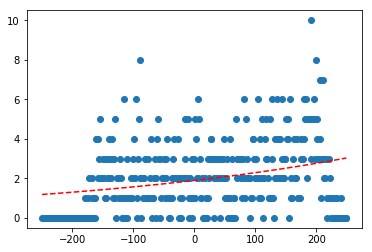

-530.9403705203564

In [16]:
def fit_exponential(x, y):
    exp = lmfit.models.ExponentialModel(prefix='exp_')
    pars = exp.guess(y, x=x)
    mod = exp
    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)
    return out.params

def fit_exponential_with_plot(x, y):
    exp = lmfit.models.ExponentialModel(prefix='exp_')
    pars = exp.guess(y, x=x)
    mod = exp
    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)
    print(out.fit_report())
    plt.figure()
    plt.plot(x, y, 'o')
    plt.plot(x, out.best_fit, 'r--')
    plt.show()
    return out.params

def get_tau_exponential(x, y):
    tau_values = []
    out = fit_exponential_with_plot(x, y)
    if out['exp_decay'].value < 1e4 and out['exp_decay'].stderr < 100:
        tau_values.append(out['exp_decay'].value)
    tau = np.mean(tau_values)
    return tau

get_tau_exponential(bins_det2, counts_det2)

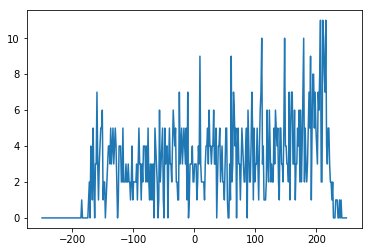

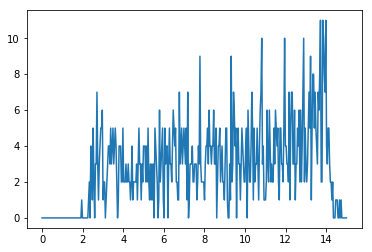

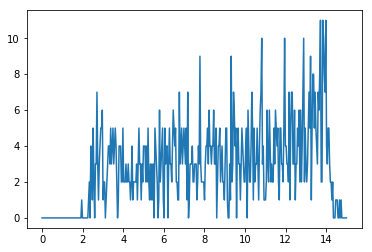

779


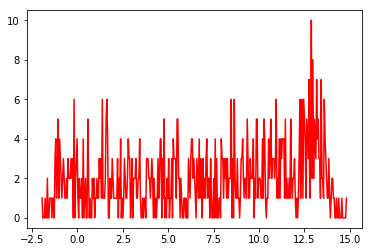

779
779


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


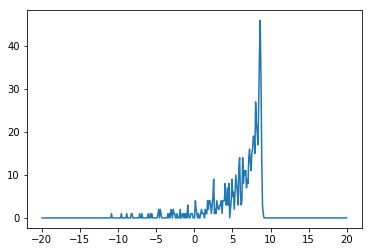

In [17]:
# method 1 = linear fit

x = (np.linspace(0, 15, len(bins_det1)))
plt.plot(bins_det1, counts_det1)
plt.show()
plt.plot(x, counts_det1)
plt.show()
m, b = np.polyfit(bins_det1, x, deg=1)
x_values = b + m * bins_det1
y_values = counts_det1
plt.plot(x_values, y_values)
plt.show()

# method 1

z_0 = 5.2  # mm
k_c = 0.04  # mm/ns
c = 3*10**8 # m/s
c = 299.792 # mm/ns
z_coord_eq_1 = []
print(len(delta_t50_values_2))
for i in delta_t50_values_2:
    z = z_0 + 0.04*(i)
    z_coord_eq_1.append(z)
    
z_coord_eq_1= np.asarray(z_coord_eq_1)#, dtype=float)
#print(type(delta_t50_1))
z_coord_eq_1_y, bin_edges = np.histogram(z_coord_eq_1, bins=400)
z_coord_eq_1_x = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(z_coord_eq_1_x, z_coord_eq_1_y,'r')
plt.show()


# method 2
z_coord_eq_2 = []
a= -140.7  #ns
b=301.8  #mm
c=0.3075  #mm^-1
d=5.033  #mm

print(len(delta_t50_values_2))
for i in delta_t50_values_2:
    l = np.log(b/(i - a))  - 1
    z = d - (l/c)
    z_coord_eq_2.append(z)
    
print(len( z_coord_eq_2))
z_coord_eq_2= np.asarray(z_coord_eq_2)#, dtype=float)
#print(type(delta_t50_1))
z_coord_eq_2_y, bin_edges = np.histogram(z_coord_eq_2, bins=400, range =[-20, 20])
z_coord_eq_2_x = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.plot(z_coord_eq_2_x, z_coord_eq_2_y)
plt.show()

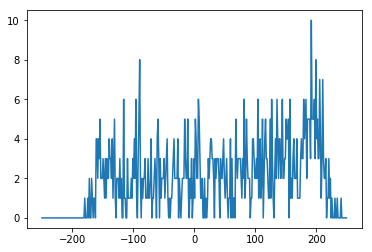

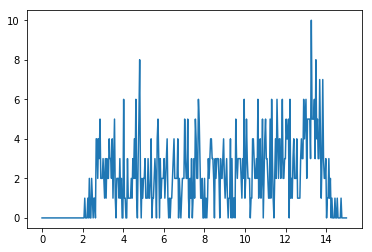

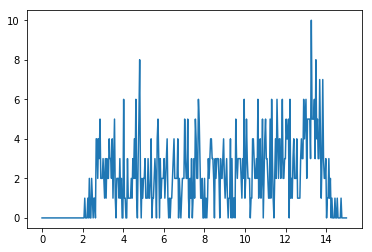

779


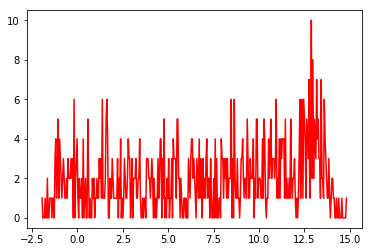

779
779


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in log


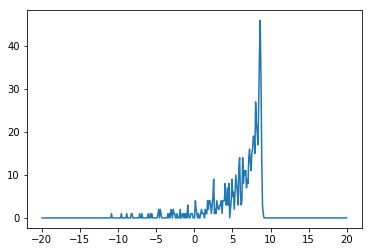

In [18]:
detector1_front = 200
detector1_back = -200
detector2_front = 200
detector2_back = -200
#x = np.linspace(detector1_front, detector1_back, 
#print(np.arange(0.0, 0.4, 0.1))
#print(np.arange(-200, 200, 10))
x = (np.linspace(0, 15, len(bins_det2)))
#print(x)
plt.plot(bins_det2, counts_det2)
plt.show()
plt.plot(x, counts_det2)
plt.show()
m, b = np.polyfit(bins_det2, x, deg=1)
#x_values = ((x - b )/ m)
x_values = b + m * bins_det2
y_values = counts_det2
plt.plot(x_values, y_values)
#plt.plot(bins_det1, counts_det1)

plt.show()

# method 1

z_0 = 5.2  # mm
k_c = 0.04  # mm/ns
c = 3*10**8 # m/s
c = 299.792 # mm/ns
z_coord_eq_1 = []
print(len(delta_t50_values_2))
for i in delta_t50_values_2:
    z = z_0 + 0.04*(i)
    z_coord_eq_1.append(z)
    
z_coord_eq_1= np.asarray(z_coord_eq_1)#, dtype=float)
#print(type(delta_t50_1))
z_coord_eq_1_y, bin_edges = np.histogram(z_coord_eq_1, bins=400)
z_coord_eq_1_x = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(z_coord_eq_1_x, z_coord_eq_1_y,'r')
plt.show()


# method 2
z_coord_eq_2 = []
a= -140.7  #ns
b=301.8  #mm
c=0.3075  #mm^-1
d=5.033  #mm

print(len(delta_t50_values_2))
for i in delta_t50_values_2:
    l = np.log(b/(i - a))  - 1
    z = d - (l/c)
    z_coord_eq_2.append(z)
    
print(len( z_coord_eq_2))
z_coord_eq_2= np.asarray(z_coord_eq_2)#, dtype=float)
#print(type(delta_t50_1))
z_coord_eq_2_y, bin_edges = np.histogram(z_coord_eq_2, bins=400, range =[-20, 20])
z_coord_eq_2_x = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.plot(z_coord_eq_2_x, z_coord_eq_2_y)
plt.show()

1128
779


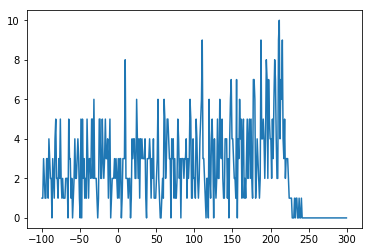

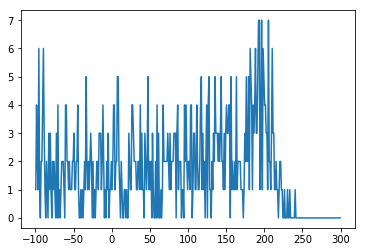

In [19]:
print(len(delta_t50_values_1))
print(len(delta_t50_values_2))
delta_t50_1 = np.asarray(delta_t50_values_1)#, dtype=float)
#print(type(delta_t50_1))
counts, bin_edges = np.histogram(delta_t50_1, bins=400, range = [-100, 300])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(bins, counts)
plt.show()

delta_t50_2 = np.asarray(delta_t50_values_2)#, dtype=float)
#print(type(delta_t50_1))
counts, bin_edges = np.histogram(delta_t50_2, bins=400, range = [-100, 300])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges

plt.plot(bins, counts)
plt.show()
#plt.hist(delta_t50_values_2)
#plt.show()

In [20]:
slopes = []
intercepts = []

#am range = [5.5e4, 6.5e4]
#cs range = [6.2e5, 7.2e5]

am_energy = 59.54
cs_energy = 661.7
        
for i in range(0, 152, 1):
    mask_am = (event_data_am['detector'] == i)
    mask_cs = (event_data_cs['detector'] == i)
    data_am = event_data_am[mask_am]
    #print('am')
    #print(len(data_am))
    data_cs = event_data_cs[mask_cs]
    #print('cs')
    #print(len(data_cs))
    
    channels_am = (data_am['detector'])
    nrgs_am = (data_am['ADC_value'])
    channels_cs = (data_cs['detector'])
    nrgs_cs = (data_cs['ADC_value'])

    if len(nrgs_cs) < 50:
        print(i, ': empty')
        slopes.append(0)
        intercepts.append(0)
    if i == 67 or i ==75 or i ==77:
        print(i, ': empty')
        slopes.append(0)
        intercepts.append(0)
    else:
        am_counts, bin_edges = np.histogram(nrgs_am, bins=256, range = [5.7e4, 6.6e4])
        am_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
        
        odd_channels = [24, 36, 39, 40, 42, 53, 55, 62, 65, 69, 80, 90, 124, 128]
        
        if i in odd_channels:
            cs_counts, bin_edges = np.histogram(nrgs_cs, bins=256, range = [5.0e5, 7.2e5])
            cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges   
        else:
            cs_counts, bin_edges = np.histogram(nrgs_cs, bins=256, range = [6.6e5, 7.2e5])
            cs_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
        
        if i == 40: # this channel has weird wide peak with high count channel right at edge and wasn't being fit properly
            fwhm, cs_centroid, err, amp = fit_gaussian_peak_linear_background_wide(cs_bins, cs_counts)
        else:
            fwhm, cs_centroid, err, amp = fit_gaussian_peak_linear_background(cs_bins, cs_counts)
        
        fwhm, am_centroid, err, amp = fit_gaussian_peak_linear_background(am_bins, am_counts)

        calibration_channels = [am_centroid, cs_centroid]
        calibration_energies = [am_energy, cs_energy]
        coefficients = calculate_coefficients(calibration_channels, calibration_energies, 1)
        if len(coefficients) == 2:
            slope = coefficients[0]
            intercept = coefficients[1]
        else:
            print "check polynomial order" 

        slopes.append(slope)
        intercepts.append(intercept)
        
        energies = np.concatenate((nrgs_am, nrgs_cs))
        energies_kev = calculate_energies(energies, slope, intercept)
        #print(energies_kev)
        
        counts, bin_edges = np.histogram(energies_kev, bins=2048, range = [40, 700])
        bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
        
        plt.figure(4, figsize=(7, 5))
        plt.cla()
        plt.clf()
        plt.axvline(59.54)
        plt.axvline(661.7)
        plt.plot(bins, counts, 'k-')
        plt.xlabel('Energy (keV)')
        plt.ylabel('Counts')
        plt.title("Calibrated Spectrum " + str(i))
        plt.legend(loc='upper right')
        plt.tight_layout()
        #plt.savefig("./figures/CalibratedSpectrum.pdf")
        plt.show()
    
f = open('../data/calibration.txt','w')
for i in range(0, len(slopes), 1):
    f.write(str(slopes[i]) + ' ' + str(intercepts[i]) + '\n')
f.close()

NameError: name 'event_data_am' is not defined

In [ ]:
filename = '../data/calibration.txt'
calibration = np.genfromtxt(filename,delimiter=' ')
slopes = calibration[:,0]
intercepts = calibration[:,1]

#nrgs_am = event_data_am['ADC_value']
#nrgs_cs = event_data_cs['ADC_value']
#channel_am = event_data_am['detector']
#channel_cs = event_data_cs['detector']
energies = event_data_cs1['ADC_value']
channels = event_data_cs1['detector']
times = 
#print(len(nrgs_am))
print(len(energies))
#print(len(channel_am))
print(len(channels))
#energies = np.concatenate((nrgs_am, nrgs_cs))
#channels = np.concatenate((channel_am, channel_cs))
print(channels)
print(energies.shape)
print(channels.shape)
energies_kev = []
for i in range(0, 152, 1):
    print(i)
    mask = (channels == i)
    nrgs = energies[mask]
    nrgs = calculate_energies(energies, slopes[i], intercepts[i])
    #print(len(nrgs))
    time.sleep(5)
    for j in nrgs:
        energies_kev.append(j)

#print(energies_kev)
counts, bin_edges = np.histogram(energies_kev, bins=2048, range = [40, 700])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
        
plt.figure(4, figsize=(7, 5))
plt.cla()
plt.clf()
plt.plot(bins, counts, 'k-')
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title("Calibrated Spectrum")
plt.legend(loc='upper right')
plt.tight_layout()
plt.axvline(59.54)
plt.axvline(661.7)
#plt.savefig("./figures/CalibratedSpectrum.pdf")
plt.show()

In [ ]:
from operator import itemgetter

In [ ]:
nrgs_cs = event_data_cs['ADC_value']
#channel_am = event_data_am['detector']
channel_cs = event_data_cs['detector']
#raw_am = event_data_am['rid']
raw_cs = event_data_cs['rid']
timestamps = event_data_cs1['timestamp']

In [ ]:
print(timestamps[0:5] * 1e-8)
print(nrgs_cs[0:5])

event_data_cs = event_data_cs[event_data_cs['timestamp'].argsort()] # First sort doesn't need to be stable.
event_data_cs = event_data_cs[event_data_cs['rid'].argsort(kind='mergesort')]
event_data_cs = event_data_cs[event_data_cs['ADC_value'].argsort(kind='mergesort')]

print(timestamps[0:5] * 1e-8)
print(nrgs_cs[0:5])

timestamps = np.diff(timestamps)
timestamps = timestamps[::-1]
timestamps[len(timestamps) + 1] = 0

#timestamps = timestamps.sort(key=lambda x: time.strptime(x, '%Y-%m-%d %H:%M:%S')[0:6])
#print(timestamps[0:5])
#print(timestamps[-5:-1])
#print(np.amin(timestamps))
#print(np.amax(timestamps))
#timestamps = timestamps - np.amin(timestamps)
print(np.amin(timestamps))
#print(np.amax(timestamps))
#timestamps = np.diff(timestamps)
#print(timestamps[0:5])

In [ ]:
counts, bin_edges = np.histogram(timestamps, bins=25, range = [0, 25])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
        
plt.figure(4, figsize=(7, 5))
plt.cla()
plt.clf()
plt.plot(bins, counts, 'ko')
plt.xlabel('timestamp difference')
plt.ylabel('ounts')
plt.title("Time-to-Next-Event Histogram")
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([0, 25])
#plt.ylim([0, 40])
#plt.axvline(59.54)
#plt.axvline(661.7)
plt.savefig("./time-to-next-event.pdf")
plt.show()

In [ ]:
filename = '../data/calibration.txt'
calibration = np.genfromtxt(filename,delimiter=' ')
slopes = calibration[:,0]
intercepts = calibration[:,1]

#nrgs_am = event_data_am['ADC_value']
nrgs_cs = event_data_cs['ADC_value']
#channel_am = event_data_am['detector']
channel_cs = event_data_cs['detector']
#raw_am = event_data_am['rid']
raw_cs = event_data_cs['rid']
#timestamps_cs = event_data_cs['timestamp']

for i in range(654831, 654832, 1):
    mask_1 = (timestamps_cs == i)
    nrgs = nrgs_cs[mask_1]
    raw_events = raw_cs[mask_1]
    nrgs = calculate_energies(nrgs, slopes[i], intercepts[i])
    ##mask_2 = ((nrgs > 658) & (nrgs < 665))
    ##nrgs = nrgs[mask_2]
   ## raw_events = raw_events[mask_2]
   # print(nrgs)
    #print(np.amin(nrgs))
    #print(np.amax(nrgs))
    
    counts, bin_edges = np.histogram(nrgs, bins=2048, range = [40, 700])
    bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges  
    
    plt.figure(4, figsize=(7, 5))
    plt.cla()
    plt.clf()
    #plt.axvline(59.54)
    plt.axvline(661.7)
    plt.plot(bins, counts, 'k-')
    plt.xlim([658,665])
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.title("Calibrated Spectrum " + str(i))
    plt.legend(loc='upper right')
    plt.tight_layout()
    #plt.savefig("./figures/CalibratedSpectrum.pdf")
    plt.show()

    ##plt.plot(raw_data_cs[(raw_events[0])])
    ##plt.plot(raw_data_cs[(raw_events[1])])
    ##plt.plot(raw_data_cs[(raw_events[2])])
    ##plt.plot(raw_data_cs[(raw_events[3])])
    ##plt.plot(raw_data_cs[(raw_events[4])])
    ##plt.plot(raw_data_cs[(raw_events[5])])
    ##plt.show()
    
    std = []
    tfifty = []
    #print(raw_events[0:10])
    #print(len(raw_events))
    for j in range(0, 10):
        index = raw_events[j]
        for l in raw_events
        t50 = calculate_t50(signal, plot=True)
        tfifty.append(t50)
        

In [ ]:
   # counts, bin_edges = np.histogram(t50, bins=2048)
   # bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges  
    


In [ ]:
face1 = np.arange(0, 38) #dc1
face2 = np.arange(38, 76) #dc2
face3 = np.arange(76, 114) #ac1
face4 = np.arange(114, 152) #ac2
print(face1)
print(face2)
print(face3)
print(face4)

In [ ]:
def calculate_t50(signal, plot=False):
  signal = signal[:-100]
  x = np.linspace(0, 1070-910, 1070-910)
  sig = savgol_filter(signal, 15, 3) # window size 51, polynomial order 3

  if sig.all() == 0:
    return -1000
  #elif np.argmax(sig) == len(sig):
  #  return -1
  else:
    grad = np.amax(np.gradient(sig)) / 10
    
    maxval = np.amax(sig)
    fiftyval = maxval* 0.5

    for i in range(0, np.argmax(sig), 1):
        if sig[i] <= fiftyval:
            fiftyindex = i

    x_fit_low = x[int(fiftyindex - 3): int(fiftyindex + 3)]
    sig_fit_low = sig[int(fiftyindex - 3): int(fiftyindex + 3)]
    x_fit_low = np.array(x_fit_low)
    sig_fit_low = np.array(sig_fit_low)
    if len(x_fit_low) < 1:
        print('x empty')
        #plt.plot(signal)
        #plt.plot(sig)
        #plt.show()
        return -1
    else:
       # print(x_fit_low)
       # print(sig_fit_low)
        m, b = np.polyfit(x_fit_low, sig_fit_low, deg=1)
        fit_low = b + m * x_fit_low
        rise_low = ((fiftyval - b )/ m)

    t50 = (rise_low) * 10# ns
    #print('fit')
    #print(rise_high)
    #print(rise_low)
    #print(risetime)
    #print('basic')
    #print(ninetyindex)
    #print(tenindex)
    #print(ninetyindex - tenindex)
    if plot==True:
        plt.figure(figsize=(10,5))
        plt.plot(signal, '-', label = 'raw signal')
        plt.plot(sig, label = 'smoothed signal')
        plt.plot(x_fit_low, fit_low,'-', linewidth = 5.0,alpha=0.7, label = 'fit')
        plt.plot(t50/10, fiftyval, 'ro', label='t50')
        plt.title('T50 Fitting')
        plt.ylabel('ADC value')
        plt.xlabel('ADC sample (10 ns sampling time)')
        plt.legend()
        #plt.savefig('t50_fitting.pdf')
        plt.show()
    return t50

In [ ]:
random_numbers = np.random.uniform(size = number_of_events)
mean_rate = 2*10**6 # MHz
time_next_event = (-np.log(random_numbers) / mean_rate)
event_times = np.cumsum(time_next_event) - time_next_event
time_differences = np.diff(event_times) * 10**9
return time_differences


In [ ]:
nrgs_am = []
for i in range(0, len(event_data_am),1):
    nrgs_am.append(event_data_am[i]['ADC_value'])
nrgs_cs = []
for i in range(0, len(event_data_cs),1):
    nrgs_cs.append(event_data_cs[i]['ADC_value'])

In [ ]:
all_counts, bin_edges = np.histogram(nrgs_20, bins=526, range = [6.2e5, 7.2e5])
#am range = [5.5e4, 6.5e4]
# cs range = [6.2e5, 7.2e5]
all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.semilogy(all_bins, all_counts, 'r')
all_counts, bin_edges = np.histogram(nrgs_21, bins=128, range = [6.2e5, 7.2e5])
all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.semilogy(all_bins, all_counts, 'g')
all_counts, bin_edges = np.histogram(nrgs_22, bins=128, range = [6.2e5, 7.2e5])
all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.semilogy(all_bins, all_counts, 'b')
plt.show()
fit_gaussian_peak_linear_background(all_bins, all_counts)

In [ ]:
channels_42 = []
nrgs_42 = []
for i in range(0, len(event_data_cs),1):
    if event_data_cs[i]['detector'] == 42:
        channels_42.append(event_data_cs[i]['detector'])
        nrgs_42.append(event_data_cs[i]['ADC_value'])
#print(channels_20)
#print(nrgs_20)
all_counts, bin_edges = np.histogram(nrgs_42, bins=1000, range = [6.1e5, 7.1e5])
all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.semilogy(all_bins, all_counts, 'b')
plt.show()

sys.exit()
channels_145 = []
nrgs_145 = []
for j in range(100, 150, 1):
    print(j)
    nrgs_145 = []
    for i in range(0, len(event_data_am),1):
        if event_data_am[i]['detector'] == j:
            #channels_145.append(event_data[i]['detector'])
            nrgs_145.append(event_data_am[i]['ADC_value'])
    all_counts, bin_edges = np.histogram(nrgs_145, bins=256, range = [5.5e4, 6.5e4])
    all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    plt.semilogy(all_bins, all_counts, 'b')
    plt.show()


In [ ]:
all_counts, bin_edges = np.histogram(nrgs_42, bins=1000, range = [6.0e4, 8e5])
all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.semilogy(all_bins, all_counts, 'b')
plt.show()

In [ ]:
all_counts, bin_edges = np.histogram(nrgs_42, bins=2048, range = [4e3, 1e5])
all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.plot(all_bins, all_counts, 'b')
plt.show()

In [ ]:
for i in range(0, 12, 1):
    mask = event_data['detector'] == i
    nrgs = event_data[mask]['ADC_value']
    all_counts, bin_edges = np.histogram(nrgs_20, bins=2048, range=[0,4e3])
    all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
    plt.semilogy(all_bins, all_counts, 'b')
    plt.show()

In [ ]:
on_bins = []
on_counts = []

for i in range(0, len(counts)):
    #print(counts[i])
    if counts[i] > 100:
        on_bins.append(bin_edges[i])
        on_counts.append(counts[i])
plt.plot( on_bins, on_counts)
plt.show()
print(np.amax(on_bins))
print(np.amin(on_bins))


all_counts, bin_edges = np.histogram(nrgs, bins=2048, range=[0,100e5])
all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.semilogy(all_bins, all_counts, 'b')
plt.show()
all_counts, bin_edges = np.histogram(nrgs, bins=2048, range=[0,0.7e5])
all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.semilogy(all_bins, all_counts, 'b')
plt.show()
all_counts, bin_edges = np.histogram(nrgs, bins=200, range=[6.7e5,7.5e5])
all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.semilogy(all_bins, all_counts, 'b')
plt.show()
all_counts, bin_edges = np.histogram(nrgs, bins=2048, range=[1e3,4e3])
all_bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.semilogy(all_bins, all_counts, 'b')
plt.show()
plt.hist(nrgs, bins=2048,  range=[0,100e5],log=True)
plt.show()

In [ ]:
print(np.amax(channels))
print(np.amin(channels))
plt.hist(channels, bins = 152, range = (0, 152))
plt.show()

counts, bin_edges = np.histogram(channels, bins=152, range=[0,152])
bins = (bin_edges[1:]+bin_edges[:-1])/2 # bin centers from bin edges
plt.plot(bins, counts, 'b')
plt.show()

for i in range(0, len(bins), 1):
    if counts[i] < 10:
        print(bins[i])